In [1]:
import sys
sys.path.insert(0, '..')

import multiprocessing as mp


In [2]:
from database.dataset import INBreast_Dataset
from general_utils.metrics import circle_comparison, quick_circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show2, simple_im_show
from mc_detection.morphology_detection import MorpholohyDetection
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np

from skimage import restoration


In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=2.0, #max 315 pixels area
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    lesion_types=['calcification', 'cluster'],
    return_indexes_in_mask=True)


In [4]:
def min_max_norm(img):
        return (img - img.min())/(img.max() - img.min())
def to_uint8(img):
        return (255*min_max_norm(img)).astype(np.uint8)
def sobel_gradient(img):
        grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        grad = np.sqrt(grad_x**2 + grad_y**2)
        return grad


In [5]:
rbd_path = Path('/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/')

md = MorpholohyDetection(rbd_path, 0.97)

In [6]:
idx = 184
image = db[idx]['img']
image_id = db.df.iloc[idx].img_id
image_mask = db[idx]['lesion_mask']
selected_cc_mask = md.predict(image, image_id)
selected_cc = np.unique(selected_cc_mask)

TP_mask = (selected_cc_mask > 0) & (image_mask > 0)
TP = np.unique(image_mask[TP_mask])

img_res = {'img_id': image_id, 'TP': len(TP), 'FP': len(selected_cc) - len(TP),
            'FN': len(np.unique(image_mask)) - len(TP) - 1}
img_res

{'img_id': 50994164, 'TP': 4, 'FP': 1065, 'FN': 0}

In [7]:
res = []

for idx in tqdm(range(len(db))):
    image = db[idx]['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db[idx]['lesion_mask']
    selected_cc_mask = md.predict(image, image_id)
    selected_cc = np.unique(selected_cc_mask)

    TP_mask = (selected_cc_mask > 0) & (image_mask > 0)
    TP = np.unique(image_mask[TP_mask])

    img_res = {'img_id': image_id, 'TP': len(TP), 'FP': len(selected_cc) - len(TP),
               'FN': len(np.unique(image_mask)) - len(TP) - 1}
    res.append(img_res)


100%|██████████| 311/311 [54:12<00:00, 10.46s/it]  


<IPython.core.display.Javascript object>

<AxesSubplot:>

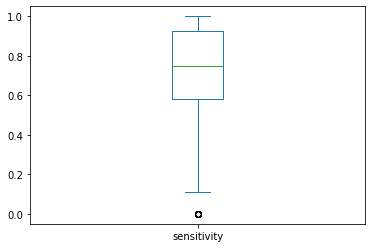

In [8]:
res_df = pd.DataFrame(res)
res_df['sensitivity'] = res_df.TP / (res_df.TP + res_df.FN)
res_df.sensitivity.plot.box()

<AxesSubplot:ylabel='Frequency'>

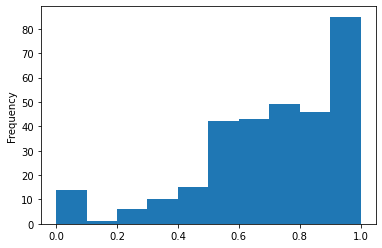

In [10]:
res_df['sensitivity'].T.plot.hist()

<IPython.core.display.Javascript object>

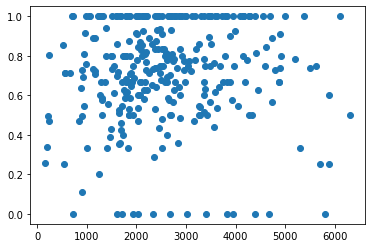

In [11]:
plt.scatter(res_df.FP.values, res_df.sensitivity.values)


In [12]:
res_df.sort_values(by=['sensitivity'])

,img_id,TP,FP,FN,sensitivity
282,53582422,0,2343,2,0.0
81,22670094,0,3949,1,0.0
72,22614266,0,3025,1,0.0
69,22614127,0,5800,1,0.0
86,22670347,0,2026,1,0.0
...,...,...,...,...,...
243,50998467,2,3128,0,1.0
241,50998413,5,3831,0,1.0
104,22679008,1,2699,0,1.0
85,22670301,4,1249,0,1.0


In [7]:
md = MorpholohyDetection(rbd_path, 0.97)